In [1]:
from model.types import MarketDemandSupply
from model.run import load_config, run, post_processing
import matplotlib.pyplot as plt
from model.mechanism.amm_k import amm_k_mechanism
from model.mechanism.treasury import liq_backing_mechanism,treasury_stables_mechanism,liq_ohm_mechanism
from model.mechanism.protocol import floating_supply_mechanism,mcap_mechanism,ratio_mechanism
from model.policy.rbs_price import lower_target_policy,upper_target_policy
from model.policy.ohmbond import generate_ohmbond


In [2]:
from itertools import product

demand_sweep = [0.007, .001]
supply_sweep = [-0.007, -.001]

sweeps = list(product(*[demand_sweep, supply_sweep]))

demand_sweep = [x[0] for x in sweeps]
supply_sweep = [x[1] for x in sweeps]

In [3]:


params = {"demand_factor": demand_sweep,
         "supply_factor": supply_sweep,
         "initial_reserves_volatile":[25000000], # setting it as constant since in this simulation we don't use it at all.
         "max_liq_ratio":[0.14375],  # LiquidityUSD : reservesUSD ratio --> 1:1 = 0.5
         "target_ma":[30], # number of days
         "lower_wall":[0.15],
         "upper_wall":[0.15],
         "lower_cushion":[.075],
         "upper_cushion":[.075],
          "reinstate_window": [30],
          "max_outflow_rate": [0.05],
          "reward_rate_policy": ["Flat"],
          "ask_factor": [0.095],  # % of floating supply that the treasury can deploy when price is trading above the upper target
          "bid_factor": [0.095],  # % of the reserves that the treasury can deploy when price is trading below the lower target
         "cushion_factor": [0.3075],  # The percentage of a bid or ask to offer as a cushion
        "min_counter_reinstate": [6],  # Number of days within the reinstate window that conditions are true to reinstate a bid or ask
         "with_reinstate_window": ['Yes'],
         "bond_create_schedule":[generate_ohmbond(amounts=[[1e6]*3],exp_durs=[[30,60,90]])]
         }


initialstate = { # variable values borrowed from liquidity-olympus/simulation.ipynb
            "liq_stables": 21000000,
            "reserves_stables":170000000,
            "reserves_volatile":25000000,
            "price":9.5,
            "reward_rate": 0.000198,

            "market_demand_supply": MarketDemandSupply(total_supply = .001,
                                                   total_demand = -0.008 ), # factors, % of OHM supply expected to drive market demand
                                                   
            # treasury policy
            'target_liq_ratio_reached':False,
            'reserves_in':0,
            'supply':25000000,

            # RBS related
            'ma_target':9.5,
            # market transaction variables
            'ask_change_ohm':0,
            'bid_change_ohm':0,
            "net_flow": None,
    "bid_capacity_target": None,
    "ask_capacity_target": None,
    "bid_capacity_target_cushion": None,
    "ask_capacity_target_cushion": None,
    "natural_price": None,
    "bid_capacity_cushion": None,
    "ask_capacity_cushion": None,
    "bid_change_cushion_usd": None,
    "bid_change_cushion_ohm": None,
    "ask_change_cushion_usd": None,
    "ask_change_cushion_ohm": None,
    "bid_change_usd": None,
    "ask_change_usd": None,
    "reserves_out": None,
    "ohm_traded": None,
    "cum_ohm_purchased": 0,
    "cum_ohm_burnt": 0,
    "cum_ohm_minted": 0
    
            }
# initialize parameters that are decided by other parameters
initialstate['amm_k'] = amm_k_mechanism(initialstate)
initialstate['price_history']=[initialstate['price']]

initialstate['lb_target'] = initialstate['ma_target']
initialstate['price_target']=initialstate['ma_target']

initialstate['liq_ohm'] = liq_ohm_mechanism(initialstate['liq_stables'],initialstate['price'])
initialstate['floating_supply'] = floating_supply_mechanism(initialstate['supply'],initialstate['liq_ohm'])


initialstate['treasury_stables'] = treasury_stables_mechanism(initialstate['liq_stables'],initialstate['reserves_stables'])
initialstate['liq_backing'] = liq_backing_mechanism(initialstate['treasury_stables'],params['initial_reserves_volatile'][0])
initialstate['lower_target_wall'] = lower_target_policy(initialstate['price_target'], params['lower_wall'][0])
initialstate['upper_target_wall'] = upper_target_policy(initialstate['price_target'], params['upper_wall'][0])
initialstate["lower_target_cushion"] = lower_target_policy(initialstate['price_target'], params['lower_cushion'][0])
initialstate["upper_target_cushion"] = upper_target_policy(initialstate['price_target'], params['upper_cushion'][0])

initialstate['bid_counter'],initialstate['ask_counter'] = [0] * params["reinstate_window"][0],[0]* params["reinstate_window"][0]


initialstate["bid_capacity_target"] = params["bid_factor"][0] * initialstate["reserves_stables"]
initialstate["ask_capacity_target"] = params["ask_factor"][0] * initialstate["reserves_stables"] / initialstate["upper_target_wall"] * (1 + params["lower_wall"][0] + params["upper_wall"][0])
initialstate["bid_capacity_target_cushion"] = initialstate["bid_capacity_target"] * params["cushion_factor"][0]
initialstate["ask_capacity_target_cushion"] = initialstate["ask_capacity_target"] * params["cushion_factor"][0]
initialstate["bid_capacity"] = initialstate["bid_capacity_target"]
initialstate["ask_capacity"] = initialstate["ask_capacity_target"]
initialstate["bid_capacity_cushion"] = initialstate["bid_capacity_target_cushion"]
initialstate["ask_capacity_cushion"] = initialstate["ask_capacity_target_cushion"]
initialstate["ask_change_ohm"] = 0
initialstate["bid_change_ohm"] = 0

# ohm bond related variables
initialstate['bond_created']=[]
initialstate['bond_created_today']=[]
initialstate['ohm_bonded']=0
initialstate['liq_ohm_into_bond']=0
initialstate['ohm_released']=0

# protocol vars
initialstate['mcap'] = mcap_mechanism(initialstate['supply'],initialstate['price'])
initialstate['floating_mcap']=mcap_mechanism(initialstate['floating_supply'],initialstate['price'])
initialstate['liq_ratio']=ratio_mechanism(initialstate['liq_stables'],initialstate['treasury_stables'])
initialstate['reserves_ratio']=ratio_mechanism( initialstate['reserves_stables'], initialstate['liq_stables']),
initialstate['fmcap_treasury_ratio']=ratio_mechanism( initialstate['floating_mcap'],initialstate['treasury_stables'])
initialstate['liq_fmcap_ratio']=ratio_mechanism(initialstate['liq_stables'] ,initialstate['floating_mcap'])
initialstate['total_demand']=initialstate['market_demand_supply'].total_demand
initialstate['total_supply']=initialstate['market_demand_supply'].total_supply
initialstate['total_net']=initialstate['total_demand']+initialstate['total_supply']

# Param tracking
initialstate['demand_factor'] = None
initialstate['supply_factor'] = None

nrun = 2
nstep = 100
exp = load_config(nrun, params, initialstate, nstep)
raw = run(exp)
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 18, 8, 63)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 18, 8, 63)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 34.78s


In [4]:
from typing import List
from pandas import DataFrame

def plot_all_sims(var_list: List[str], df: DataFrame):
    for col in var_list:
        df.pivot("timestep","unique_id", col).plot(kind='line')
        plt.title(col)
        plt.legend([])
        plt.show()
        
def plot_grouped_variables_average(var_list: List[str], grouping_variables: List[str], df: DataFrame):
    data = df.groupby(grouping_variables + ["timestep"])[var_list].mean()
    for col in var_list:
        data[col].unstack(-1).T.plot(kind='line')
        plt.title(col)
        plt.show()

In [5]:
var_list = ["reserves_in","reserves_out"]
grouping_variables = ["demand_factor", "supply_factor"]
df.groupby(grouping_variables + ["timestep"])[var_list].mean()["reserves_in"].unstack(-1).T

demand_factor         0.001                        0.007              
supply_factor        -0.007         -0.001        -0.007        -0.001
timestep                                                              
0              0.000000e+00       0.000000  0.000000e+00  0.000000e+00
1              0.000000e+00       0.000000  0.000000e+00  0.000000e+00
2              0.000000e+00       0.000000  0.000000e+00  0.000000e+00
3              0.000000e+00       0.000000  0.000000e+00  0.000000e+00
4              0.000000e+00       0.000000  0.000000e+00  0.000000e+00
...                     ...            ...           ...           ...
96             0.000000e+00       0.000000  0.000000e+00  0.000000e+00
97             0.000000e+00       0.000000  0.000000e+00  0.000000e+00
98            -1.324986e+06 -131886.835332 -1.736020e+06  2.774248e+06
99             0.000000e+00       0.000000  0.000000e+00  0.000000e+00
100            0.000000e+00       0.000000  0.000000e+00  0.000000e+00

[101 rows x 4 columns]

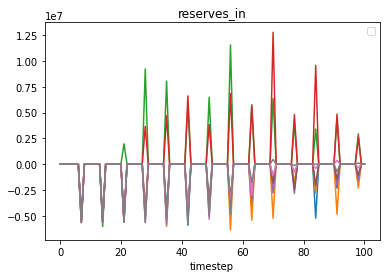

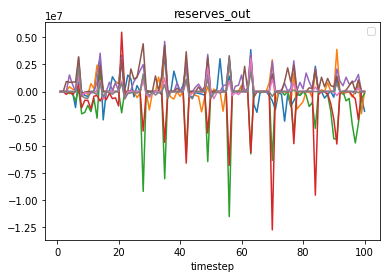

In [8]:
plot_all_sims(["reserves_in","reserves_out"], df)

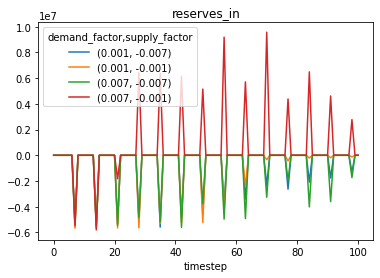

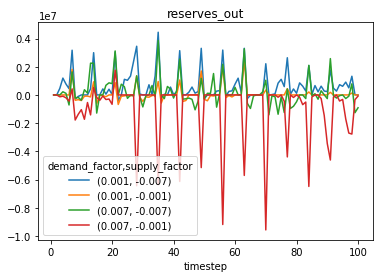

In [9]:
plot_grouped_variables_average(["reserves_in","reserves_out"],
                               ["demand_factor", "supply_factor"],
                               df)

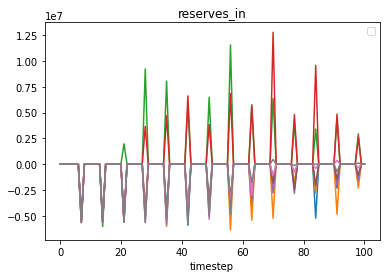

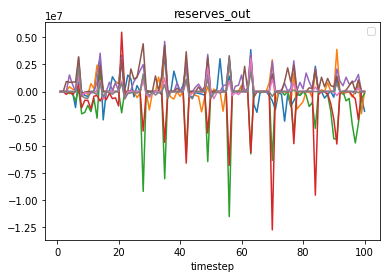